# **(Predict House Price Nootebook)**

## Objectives

* Develop and assess a predictive model for estimating the sale values of inherited properties.

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csvk

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot
* Model performance plot 

## Additional Comments

* In the begining of the project we made an hypothesis, after the taken steps we can make an conclusion that the hypothesis was true, we see that size, quality and the year the house was built matters on the price. I will also credit coce institute and https://github.com/Amareteklay/ who i followed. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Housepriceissues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Housepriceissues'

# Load Data

Start by loading data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv") 

print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# MP Pipeline: Regressor

### Import necessary libraries & Create pipline

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Models
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def OptimizeModelPipeline(model):
    pipeline = Pipeline([
        ('impute_mean', MeanMedianImputer(imputation_method='mean', variables=['LotFrontage', 'BedroomAbvGr'])),
        ('impute_median', MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea'])),
        ('impute_categorical', CategoricalImputer(imputation_method='frequent', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),
        ('drop_features', DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF'])), 
        ('encoder', OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ('log_transformer', vt.LogTransformer(variables=['GrLivArea', 'LotArea', 'LotFrontage'])),
        ('power_transformer', vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])),
        ('outlier_handler', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])),  
        ('smart_corr_sel', SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ('feat_scaling', StandardScaler()),
        ('feat_selection', SelectFromModel(model)),
        ('model', model)
    ])

    return pipeline


* Code inpiered and taken from code institute walktrough

In [47]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.models.keys():
            try:
                print(f"\nRunning GridSearchCV for {key}\n")
                model = self.models[key]
                params = self.params[key]
                gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, error_score='raise')
                gs.fit(X, y)
                self.grid_searches[key] = gs
            except Exception as e:
                print(f"Error encountered for model {key}: {e}")
                continue

        return self.grid_searches
 

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))
        
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Set

In [11]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into features (X) and target (y)
features = df.drop(columns=['SalePrice'])
target = df['SalePrice']

# Dividing the data into training and testing sets
X_train, X_test,y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=0
)

# Displaying the dimensions of the splits
print("* Dimensions of Training Data:", X_train.shape, y_train.shape)
print("* Dimensions of Testing Data:", X_test.shape, y_test.shape)


* Dimensions of Training Data: (1168, 23) (1168,)
* Dimensions of Testing Data: (292, 23) (292,)


## Grid Search CV - Sklearn

Use default hyperparameters to find most suitable algorithm

In [12]:

# Set up a dictionary of various regression models with default settings
initial_models = {
    "Linear_Reg": LinearRegression(),
    "Decision_Tree": DecisionTreeRegressor(random_state=0),
    "Random_Forest": RandomForestRegressor(random_state=0),
    "Extra_Trees": ExtraTreesRegressor(random_state=0),
    "AdaBoost": AdaBoostRegressor(random_state=0),
    "Gradient_Boosting": GradientBoostingRegressor(random_state=0),
    "XGBoost": XGBRegressor(random_state=0),
}

# Define hyperparameters for a quick comparison of models
model_hyperparams = {
    "Linear_Reg": {},

    "Decision_Tree": {
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "Random_Forest": {
        'model__n_estimators': [100, 50, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "Extra_Trees": {
        'model__n_estimators': [100, 50, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
    },

    "AdaBoost": {
        'model__n_estimators': [50, 25, 80, 150],
        'model__learning_rate': [1, 0.1, 2],
        'model__loss': ['linear', 'square', 'exponential'],
    },

    "Gradient_Boosting": {
        'model__n_estimators': [100, 50, 140],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 15, None],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "XGBoost": {
        'model__n_estimators': [30, 80, 200],
        'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}


In [19]:
search = HyperparameterOptimizationSearch(models=initial_models, params=model_hyperparams)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for Linear_Reg 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for Decision_Tree 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for Random_Forest 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for Extra_Trees 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoost 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for Gradient_Boosting 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBoost 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


* We run a summary and check results

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
98,Extra_Trees,0.658724,0.769975,0.814568,0.057985,None,NaN,1,2,50,NaN,NaN,NaN
97,Extra_Trees,0.665815,0.769734,0.818507,0.056908,None,NaN,1,2,100,NaN,NaN,NaN
99,Extra_Trees,0.665675,0.769135,0.813976,0.056911,None,NaN,1,2,150,NaN,NaN,NaN
75,Random_Forest,0.656732,0.768027,0.825929,0.059984,15,None,1,2,140,NaN,NaN,NaN
27,Random_Forest,0.658047,0.76768,0.826751,0.059286,None,None,1,2,140,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,XGBoost,0.009284,0.028057,0.040848,0.010455,None,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBoost,0.009727,0.027983,0.039301,0.010011,15,NaN,NaN,NaN,30,0.001,NaN,0
436,XGBoost,0.009727,0.027983,0.039301,0.010011,15,NaN,NaN,NaN,30,0.001,NaN,0.1
406,XGBoost,0.006152,0.026362,0.037735,0.010675,3,NaN,NaN,NaN,30,0.001,NaN,0


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.

* The first step we take is to create a model with parameters

In [21]:
initial_models = {
    "Extra_Trees": ExtraTreesRegressor(random_state=0),
}
model_hyperparams = {
    "Extra_Trees":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}


* Then we do as before and running an extensive GridSearch CV

In [22]:
search = HyperparameterOptimizationSearch(models=initial_models, params= model_hyperparams)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for Extra_Trees 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


* We then use the same code and step as before to se the summary/result

In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,Extra_Trees,0.658724,0.769975,0.814568,0.057985,None,1,2,50
1,Extra_Trees,0.665815,0.769734,0.818507,0.056908,None,1,2,100
2,Extra_Trees,0.665675,0.769135,0.813976,0.056911,None,1,2,150
25,Extra_Trees,0.656763,0.765687,0.81847,0.061888,15,1,2,100
26,Extra_Trees,0.658335,0.765465,0.81642,0.059882,15,1,2,150
4,Extra_Trees,0.704459,0.764832,0.812889,0.045964,None,1,50,100
28,Extra_Trees,0.704459,0.764795,0.812978,0.046148,15,1,50,100
3,Extra_Trees,0.701603,0.764555,0.814408,0.046545,None,1,50,50
27,Extra_Trees,0.701603,0.764131,0.814586,0.046535,15,1,50,50
29,Extra_Trees,0.702095,0.763948,0.810724,0.045205,15,1,50,150


* We looking for the optimize model

In [24]:
optimal_model = grid_search_summary.iloc[0]['estimator']
optimal_model

'Extra_Trees'

* Extract the best parameters for the top-performing model

In [25]:
optimal_parameters = grid_search_pipelines[optimal_model].best_params_
optimal_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

* Assign the most effective regression model from the grid search results

In [26]:
optimal_regression_pipeline = grid_search_pipelines[optimal_model].best_estimator_
optimal_regression_pipeline

Pipeline(steps=[('impute_mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('impute_median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('impute_categorical',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('drop_features',
                 DropFeatures(f...
                                       'MasVnrArea', 'OpenPorchSF',
                                       'TotalBsmtSF', '1stFlrSF',
                                       '2ndFlrSF'])),
                ('smart_corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

## Assess feature importance

The model focuses on these 6 key features, listed in order of importance: 
['TotalBsmtSF', 'GarageArea', 'YearBuilt', '2ndFlrSF', 'YearRemodAdd', 'KitchenQual']


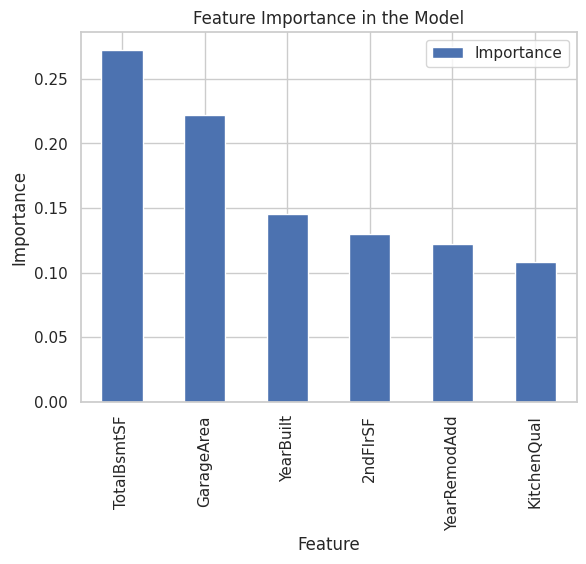

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting the style for the plot
sns.set_theme(style="whitegrid")

# Define the number of steps in the pipeline related to data cleaning and feature engineering
initial_pipeline_steps = 9

# Extract the feature names after the initial steps of the pipeline
featured_columns_post_processing = Pipeline(optimal_regression_pipeline.steps[:initial_pipeline_steps]).transform(X_train).columns

# Identifying the significant features based on the selection from the model
important_features = featured_columns_post_processing[optimal_regression_pipeline['feat_selection'].get_support()]

# Creating a DataFrame for the importance of each feature
df_feature_importance = pd.DataFrame({
    'Feature': important_features,
    'Importance': optimal_regression_pipeline.named_steps['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Displaying the key features and their importance
print(f"The model focuses on these {len(important_features)} key features, listed in order of importance: \n{df_feature_importance['Feature'].to_list()}")

# Plotting the feature importance
df_feature_importance.set_index('Feature').plot(kind='bar')
plt.title("Feature Importance in the Model")
plt.ylabel("Importance")
plt.show()


## Evaluate on Train and Test Sets

We put as BR2 to have a score on both train and test set on 0.75 so we need to check the performance

In [28]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    r2_train = regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    r2_test = regression_evaluation(X_test, y_test, pipeline)

    # Performance Check
    check_performance_goal(r2_train, r2_test)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    r2 = r2_score(y, prediction)
    print('R2 Score:', r2.round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")
    return r2

def check_performance_goal(r2_train, r2_test):
    if r2_train < 0.75:
        print("Warning: R2 score on the train set is below the goal of 0.75.")
    if r2_test < 0.75:
        print("Warning: R2 score on the test set is below the goal of 0.75.")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_title(f"Train Set - R2: {r2_train:.3f}")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_title(f"Test Set - R2: {r2_test:.3f}")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")

    directory = 'docs/plots'
    if not os.path.exists(directory):
        os.makedirs(directory)


    plt.savefig('docs/plots/regression_performance.png', bbox_inches='tight')  
    plt.show()

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 130.241
Mean Squared Error: 855959.757
Root Mean Squared Error: 925.181


* Test Set
R2 Score: 0.815
Mean Absolute Error: 22229.715
Mean Squared Error: 1276933332.221
Root Mean Squared Error: 35734.204




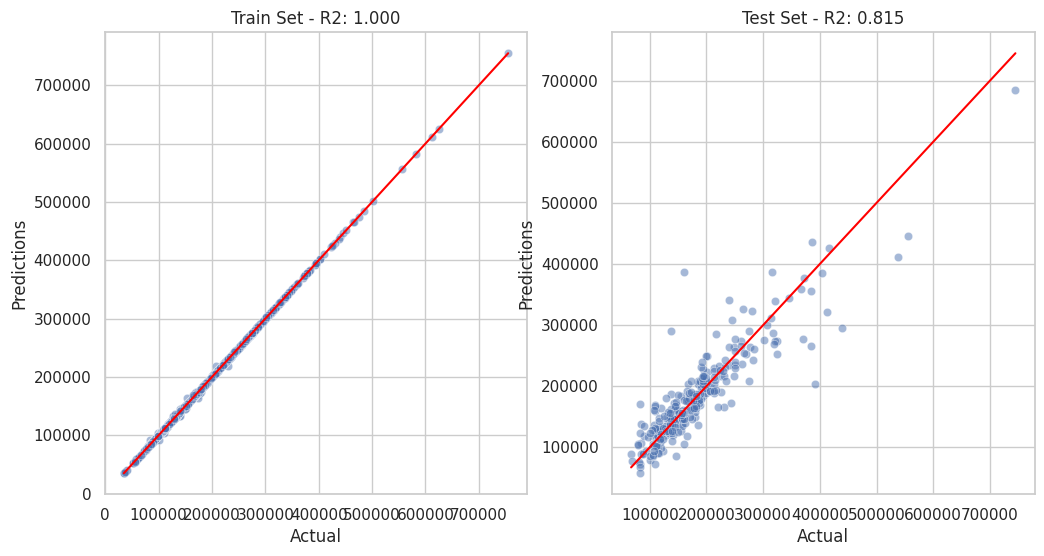

In [29]:
regression_performance(X_train, y_train, X_test, y_test, optimal_regression_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, optimal_regression_pipeline)


* We achived the BR2 

## Pipeline

In [30]:
optimal_regression_pipeline

Pipeline(steps=[('impute_mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('impute_median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('impute_categorical',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('drop_features',
                 DropFeatures(f...
                                       'MasVnrArea', 'OpenPorchSF',
                                       'TotalBsmtSF', '1stFlrSF',
                                       '2ndFlrSF'])),
                ('smart_corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

## Refit pipeline with best features

### Rewrite Pipeline

In [65]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer, PowerTransformer
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

def OptimizeModelPipeline(model):
    pipeline = Pipeline([
        # Imputation
        ('impute_mean', MeanMedianImputer(imputation_method='mean', variables=['TotalBsmtSF'])),
        ('impute_median', MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF'])),
        # Transformation
        ('power_transformer', PowerTransformer(variables=['GarageArea', 'TotalBsmtSF'])),

        # Outlier Handling
        ('outlier_handler', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GarageArea', 'TotalBsmtSF', '2ndFlrSF'])),

        # Scaling
        ('feat_scaling', StandardScaler()),

        # Feature Selection
        ('feat_selection', SelectFromModel(model)),

        # Model
        ('model', Extra_Trees(max_depth=15, min_samples_split=50,
                                     n_estimators=150, random_state=0))])


    return pipeline


## Split Train & Test Set with the omptimize features

In [32]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into features (X) and target (y)
features = df[important_features]
target = df['SalePrice']

# Dividing the data into training and testing sets
X_train, X_test,y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=0
)

# Displaying the dimensions of the splits
print("* Dimensions of Training Data:", X_train.shape, y_train.shape)
print("* Dimensions of Testing Data:", X_test.shape, y_test.shape)
X_train.head()

* Dimensions of Training Data: (1168, 6) (1168,)
* Dimensions of Testing Data: (292, 6) (292,)


,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,0.0,774,Gd,1822,2007,2007
870,0.0,308,TA,894,1962,1962
92,0.0,432,TA,876,1921,2006
817,0.0,857,Gd,1568,2002,2002
302,0.0,843,Gd,1541,2001,2002


## Grid Search CV – Sklearn

* We are going to follow the same steps taken before

In [33]:
initial_models

{'Extra_Trees': ExtraTreesRegressor(random_state=0)}

In [34]:
model_hyperparams

{'Extra_Trees': {'model__n_estimators': [50, 100, 150],
  'model__max_depth': [None, 3, 15],
  'model__min_samples_split': [2, 50],
  'model__min_samples_leaf': [1, 50]}}

In [53]:
params_search = {
    "Extra_Trees":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}



In [62]:
from sklearn.ensemble import ExtraTreesRegressor
search = HyperparameterOptimizationSearch(models=initial_models, params=model_hyperparams)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for Extra_Trees

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Error encountered for model Extra_Trees: Invalid parameter 'model' for estimator ExtraTreesRegressor(random_state=0). Valid parameters are: ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].


{}

---

# Push files to Repo

* this part is totally taken from https://github.com/Amareteklay who i give credit to.

In [66]:
import joblib
import os

version = 'v4'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

### Train Set : features and target

In [67]:
X_train.head()

,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,0.0,774,Gd,1822,2007,2007
870,0.0,308,TA,894,1962,1962
92,0.0,432,TA,876,1921,2006
817,0.0,857,Gd,1568,2002,2002
302,0.0,843,Gd,1541,2001,2002


In [68]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [69]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [70]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: features and target

In [71]:
X_test.head()

,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,0.0,484,TA,2035,1957,1975
491,620.0,240,Fa,806,1941,1950
459,224.0,352,Gd,709,1950,1950
279,866.0,505,TA,1160,1977,1977
655,NaN,264,TA,525,1971,1971


In [72]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [73]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [74]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling pipeline

In [75]:
optimal_regression_pipeline

Pipeline(steps=[('impute_mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('impute_median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('impute_categorical',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('drop_features',
                 DropFeatures(f...
                                       'MasVnrArea', 'OpenPorchSF',
                                       'TotalBsmtSF', '1stFlrSF',
                                       '2ndFlrSF'])),
                ('smart_corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

In [76]:
joblib.dump(value=optimal_regression_pipeline, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v4/regression_pipeline.pkl']

## Feature importance plot

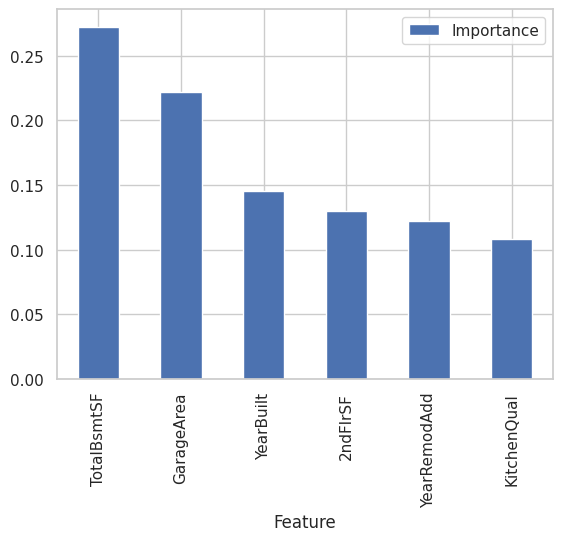

In [77]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

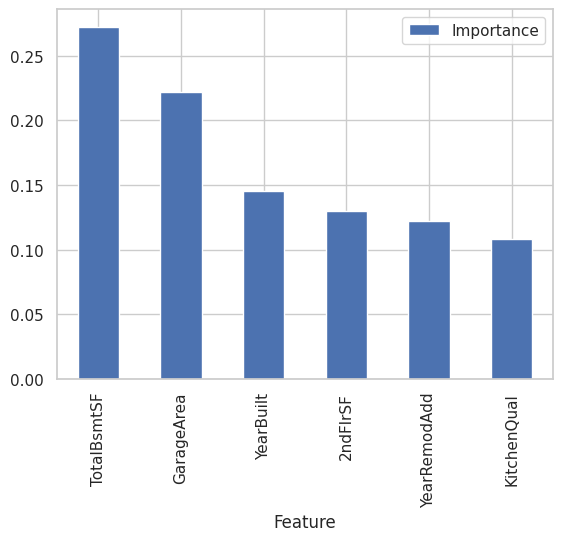

In [78]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')
## Save to docs folder for documentation
plt.savefig(f'docs/plots/features_importance.png', bbox_inches='tight') 